<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPORT-PACKAGES" data-toc-modified-id="IMPORT-PACKAGES-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPORT PACKAGES</a></span><ul class="toc-item"><li><span><a href="#Import-customize-functions-for-fitting-data" data-toc-modified-id="Import-customize-functions-for-fitting-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import customize functions for fitting data</a></span></li></ul></li><li><span><a href="#LOAD-DATA" data-toc-modified-id="LOAD-DATA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LOAD DATA</a></span><ul class="toc-item"><li><span><a href="#Amplification-data-&amp;-Melting-curves-DATAFRAMEs" data-toc-modified-id="Amplification-data-&amp;-Melting-curves-DATAFRAMEs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Amplification data &amp; Melting curves DATAFRAMEs</a></span></li></ul></li><li><span><a href="#DATA-PROCESSING" data-toc-modified-id="DATA-PROCESSING-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DATA PROCESSING</a></span><ul class="toc-item"><li><span><a href="#Amplification-curve-background-subtraction" data-toc-modified-id="Amplification-curve-background-subtraction-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Amplification curve background-subtraction</a></span></li><li><span><a href="#Melting-curve-processing" data-toc-modified-id="Melting-curve-processing-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Melting curve processing</a></span></li><li><span><a href="#Master-DF-True-Positives" data-toc-modified-id="Master-DF-True-Positives-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Master DF True Positives</a></span></li></ul></li><li><span><a href="#DATA-VISUALIZATION" data-toc-modified-id="DATA-VISUALIZATION-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DATA VISUALIZATION</a></span><ul class="toc-item"><li><span><a href="#Amplification-curve-visualization" data-toc-modified-id="Amplification-curve-visualization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Amplification curve visualization</a></span></li><li><span><a href="#Standard-Curve" data-toc-modified-id="Standard-Curve-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Standard Curve</a></span></li><li><span><a href="#Melting-curve-visualization" data-toc-modified-id="Melting-curve-visualization-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Melting curve visualization</a></span></li></ul></li></ul></div>

# IMPORT PACKAGES

In [101]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('..')

from tqdm.auto import tqdm

import time
from datetime import datetime

## Import customize functions for fitting data

In [103]:
import functions.fitting_func as fitfunc
import functions.peak_finder as peakfunc
import functions.plotting_func as plotfunc
import functions.utilities as utils

utils.colourblind() # load colourblind lib

# LOAD DATA

## Amplification data & Melting curves DATAFRAMEs

In [104]:
df_qAC_raw = pd.read_csv("../data/df_raw_AC_qPCR.csv", low_memory=False)
df_qMC_raw = pd.read_csv("../data/df_raw_MC_qPCR.csv", low_memory=False)

df_qAC_raw.loc[:, df_qAC_raw.dtypes=='float64'] = df_qAC_raw.loc[:, df_qAC_raw.dtypes=='float64'].astype('float16')
df_qMC_raw.loc[:, df_qMC_raw.dtypes=='float64'] = df_qMC_raw.loc[:, df_qMC_raw.dtypes=='float64'].astype('float16')

df_qAC_raw.head()

,Target,Assay,Conc,1,2,3,4,5,6,7,...,36,37,38,39,40,41,42,43,44,45
0,IMP-1,CPE_5_plex,1,0.050171,0.050842,0.051270,0.051880,0.052307,0.052521,0.052612,...,0.056641,0.056885,0.056763,0.057343,0.057404,0.057587,0.057587,0.057831,0.057861,0.057983
1,IMP-1,CPE_5_plex,1,0.060455,0.061096,0.061676,0.062073,0.062561,0.063110,0.063293,...,0.066956,0.067261,0.067139,0.067383,0.067688,0.067871,0.068115,0.068237,0.068359,0.068420
2,IMP-1,CPE_5_plex,10,0.053162,0.054047,0.054565,0.054932,0.055298,0.055450,0.055573,...,0.132080,0.160522,0.189819,0.218750,0.245728,0.270752,0.294434,0.314941,0.333984,0.350342
3,IMP-1,CPE_5_plex,10,0.049805,0.050690,0.051208,0.051514,0.051788,0.052032,0.052155,...,0.134766,0.161377,0.187866,0.213989,0.238159,0.260498,0.281006,0.299316,0.316162,0.330811
4,IMP-1,CPE_5_plex,100,0.047821,0.048828,0.049347,0.049744,0.050049,0.050293,0.050385,...,0.179932,0.204102,0.227539,0.248901,0.268799,0.287598,0.304199,0.319336,0.333740,0.346191


# DATA PROCESSING

## Amplification curve background-subtraction

In [105]:
qNMETA = 3

# background removal from amplification curves
remove_bs = lambda x: fitfunc.remove_background(x, order=0, n_ct_fit=5, n_ct_skip=3)
df_qAC_bs = utils.apply_processing(df_qAC_raw, func=remove_bs, N=qNMETA)

## Melting curve processing

In [106]:
# Interpolating Melting curve values
df_qMC_interpol = utils.apply_func_to_columns(df_qMC_raw, N=qNMETA, func=utils.interpolate_melting)

# Melting peaks finder
df_qMC_peak = df_qMC_interpol.iloc[:, :qNMETA].copy() # copy META
df_qMC_interpol_no_meta = df_qMC_interpol.iloc[:, qNMETA:].transpose()
df_qMC_peak['MeltPeaks'] = peakfunc.find_peaks(df_qMC_interpol_no_meta)

  0%|          | 0/80 [00:00<?, ?it/s]

## Master DF True Positives

In [107]:
# Creating a Master_DF with MC peaks and AC values
df_qPCR_master = df_qMC_peak.join(df_qAC_bs.iloc[:, qNMETA:])
df_qPCR_master.head()

,Target,Assay,Conc,MeltPeaks,1,2,3,4,5,6,...,36,37,38,39,40,41,42,43,44,45
0,IMP-1,CPE_5_plex,1,[],-0.002258,-0.001587,-0.001160,-0.000549,-0.000122,0.000092,...,0.004211,0.004456,0.004333,0.004913,0.004974,0.005157,0.005157,0.005402,0.005432,0.005554
1,IMP-1,CPE_5_plex,1,[],-0.002411,-0.001770,-0.001190,-0.000793,-0.000305,0.000244,...,0.004089,0.004395,0.004272,0.004517,0.004822,0.005005,0.005249,0.005371,0.005493,0.005554
2,IMP-1,CPE_5_plex,10,[81.41829712538963],-0.002197,-0.001312,-0.000793,-0.000427,-0.000061,0.000092,...,0.076721,0.105164,0.134521,0.163330,0.190430,0.215332,0.239014,0.259521,0.278564,0.294922
3,IMP-1,CPE_5_plex,10,[81.42377391459394],-0.002136,-0.001251,-0.000732,-0.000427,-0.000153,0.000092,...,0.082825,0.109436,0.135986,0.162109,0.186279,0.208496,0.229004,0.247314,0.264160,0.278809
4,IMP-1,CPE_5_plex,100,[81.4006507820428],-0.002380,-0.001373,-0.000854,-0.000458,-0.000153,0.000092,...,0.129761,0.153931,0.177368,0.198730,0.218628,0.237427,0.253906,0.269043,0.283447,0.295898


# DATA VISUALIZATION

## Amplification curve visualization

In [108]:
df_qPCR_master = df_qPCR_master.loc[df_qPCR_master["Target"]!="NTC"]

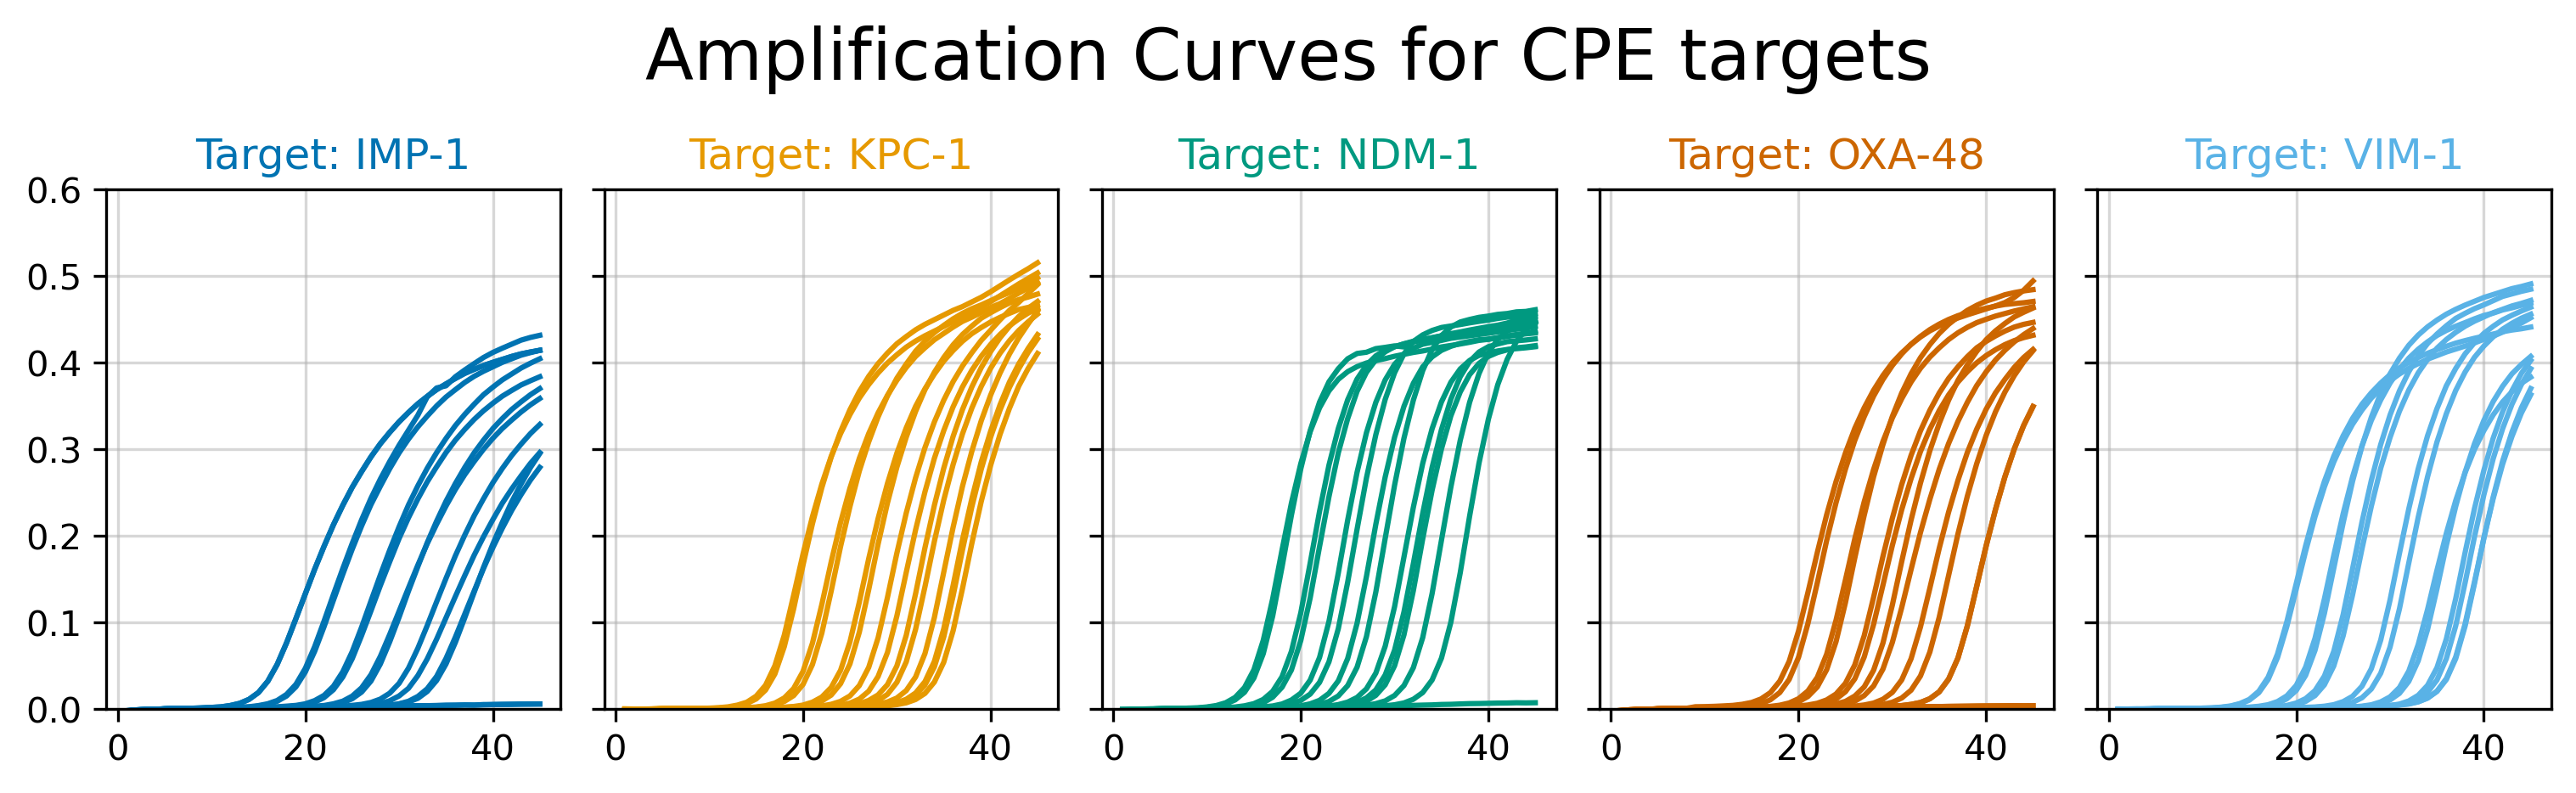

In [109]:
fig, ax = plt.subplots(1, 5, figsize=(10, 3), dpi=300, constrained_layout=True)
fig.suptitle("Amplification Curves for CPE targets", fontsize=20)
ax = ax.flatten()

for i, (target, df) in enumerate(df_qPCR_master.groupby('Target')):
    ax[i].set_title(f"Target: {target}", c=f"C{i}")
    
    curves = df.iloc[:, qNMETA+1:]
    curves.columns = curves.columns.astype(float)
    curves = curves.transpose()
    
    ax[i].plot(curves.index, curves.values, c=f"C{i}")
    ax[i].grid(alpha=0.5)
    ax[i].set_ylim((0, 0.6))

    
    if i>0:
        ax[i].set_yticklabels([])

plt.show()

## Standard Curve

In [110]:
df_plot = df_qPCR_master.loc[df_qPCR_master.Conc != 1]
df_plot2 = df_plot.loc[df_plot.Target!='NTC']
x = df_plot2.iloc[:,qNMETA+1:]
x.columns = x.columns.astype(float)
x = x.T

In [111]:
cts = fitfunc.compute_cts(x, thresh=0.1)

df_temp = df_plot2.iloc[:,:qNMETA]
df_cts = df_temp.join(cts)

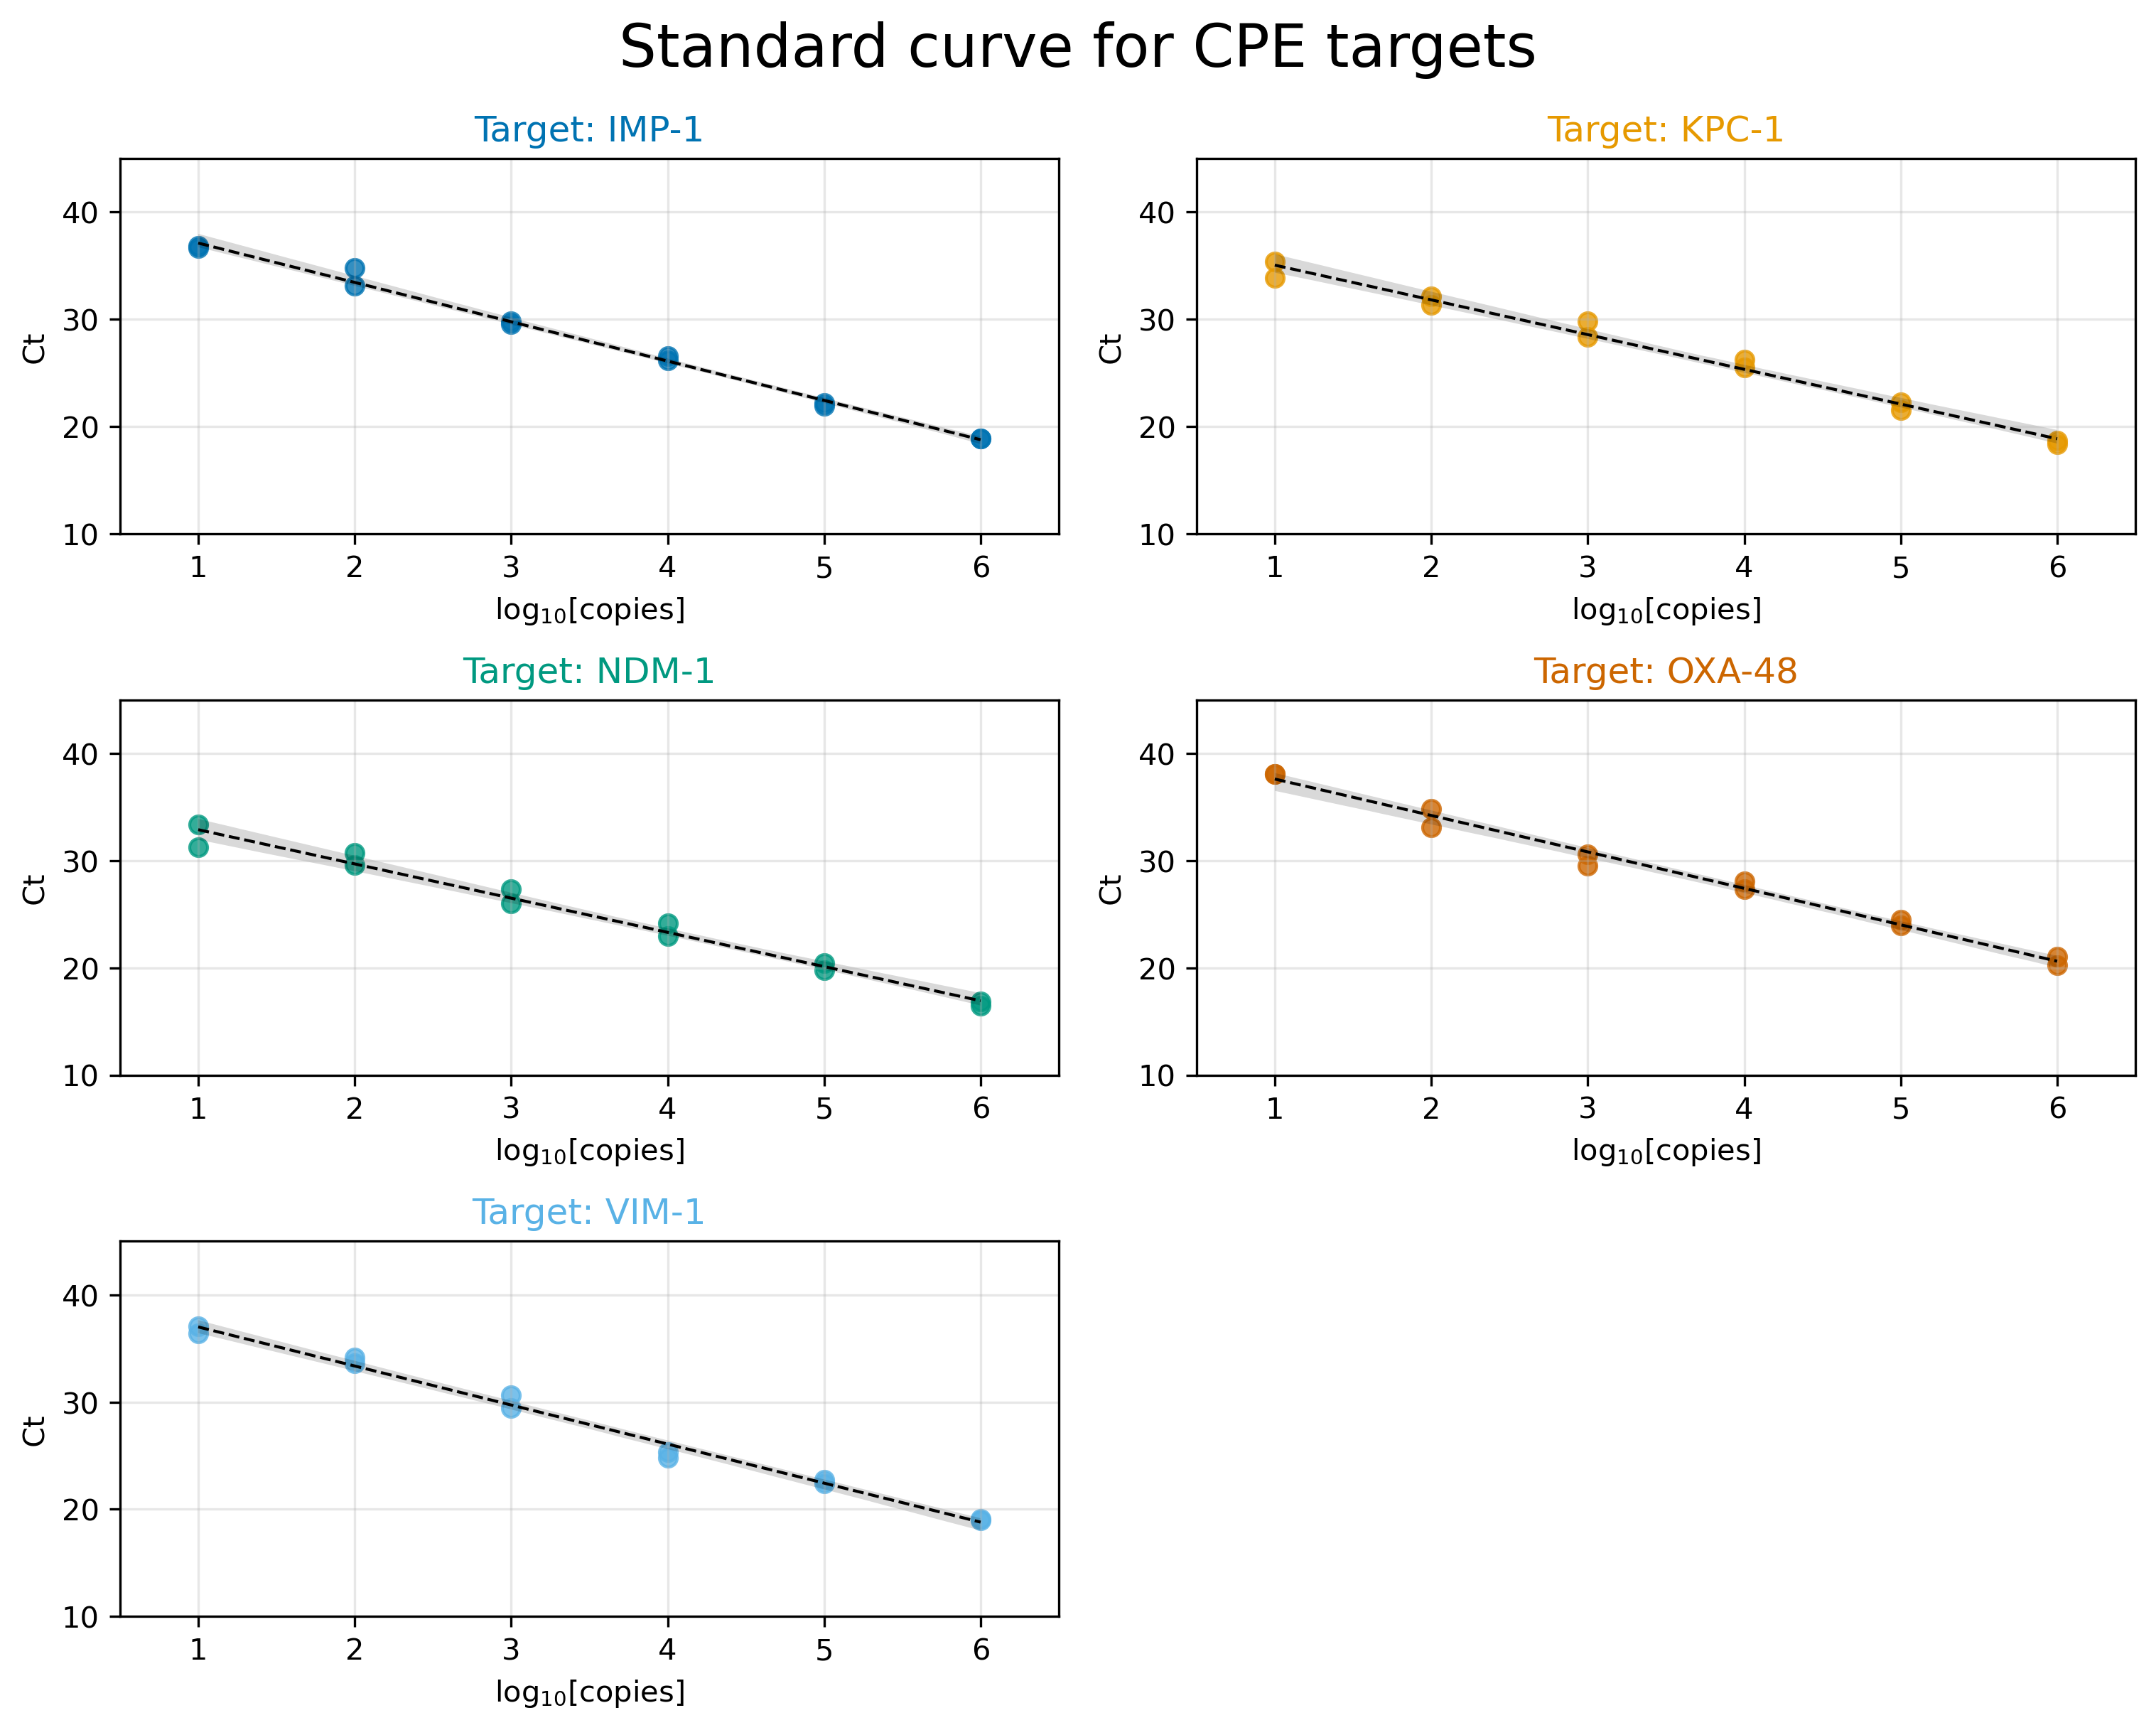

In [112]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8), dpi=300, constrained_layout=True)
fig.suptitle("Standard curve for CPE targets", fontsize=20)
ax = ax.flatten()

for i, (target, df) in enumerate(df_cts.groupby('Target')):
    ax[i].set_title(f"Target: {target}", c=f"C{i}")
    
#     ax[i].set_xscale("log")
    sns.regplot(x=np.log10(df.Conc.astype(float)), y=df.Ct, order=0, ax=ax[i],
                color=f"C{i}", line_kws={"color": "black"})
    

    ax[i].set_xlabel('$\log_{10}$[copies]')
    
    ax[i].lines[0].set_linestyle("--")
    ax[i].lines[0].set_linewidth(1)
    ax[i].grid(alpha=0.3)
    ax[i].set_ylim((10, 45))
    ax[i].set_xlim((0.5, 6.5))

ax[-1].set_visible(False)
plt.show()

In [113]:
import statsmodels.api as sm
targets = []
ms = []
cs = []
rsqrs = []
effs = []

for target, df_ in df_cts.groupby('Target'):

    x_ = np.log10(df_['Conc'].astype(float))
    y_ = df_['Ct']

    model = sm.OLS(y_, sm.add_constant(x_))
    
    results = model.fit()
    
    m = results.params["Conc"]
    c = results.params["const"]
    rsqr = results.rsquared
    eff = 100 * (10**(-1/results.params["Conc"]) - 1)
    
    ms.append(m)
    cs.append(c)
    rsqrs.append(rsqr)
    effs.append(eff)
    targets.append(target)
    
display(results.summary())

/Users/Luca/opt/anaconda3/envs/MultiplexAnalysis/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/Luca/opt/anaconda3/envs/MultiplexAnalysis/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Ct   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1035.
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           1.99e-11
Time:                        17:23:24   Log-Likelihood:                -11.127
No. Observations:                  12   AIC:                             26.25
Df Residuals:                      10   BIC:                             27.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6477      0.441     92.169      0.000      39.665      41.630
Conc          -3.6424      0.113    -32.165      0.000      -3.895      -3.390
==============================================================================
Omnibus:                        0.927   Durbin-Watson:                   1.457
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.542
Skew:                          -0.485   Prob(JB):                        0.762
Kurtosis:                       2.622   Cond. No.                         9.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Melting curve visualization

<AxesSubplot:>

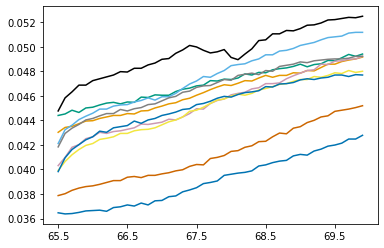

In [114]:
ntc = df_qMC_raw.loc[df_qMC_raw.Target=='NTC']
ntc.iloc[:,qNMETA:].T.plot(legend=False)

# FLAT = GOOD

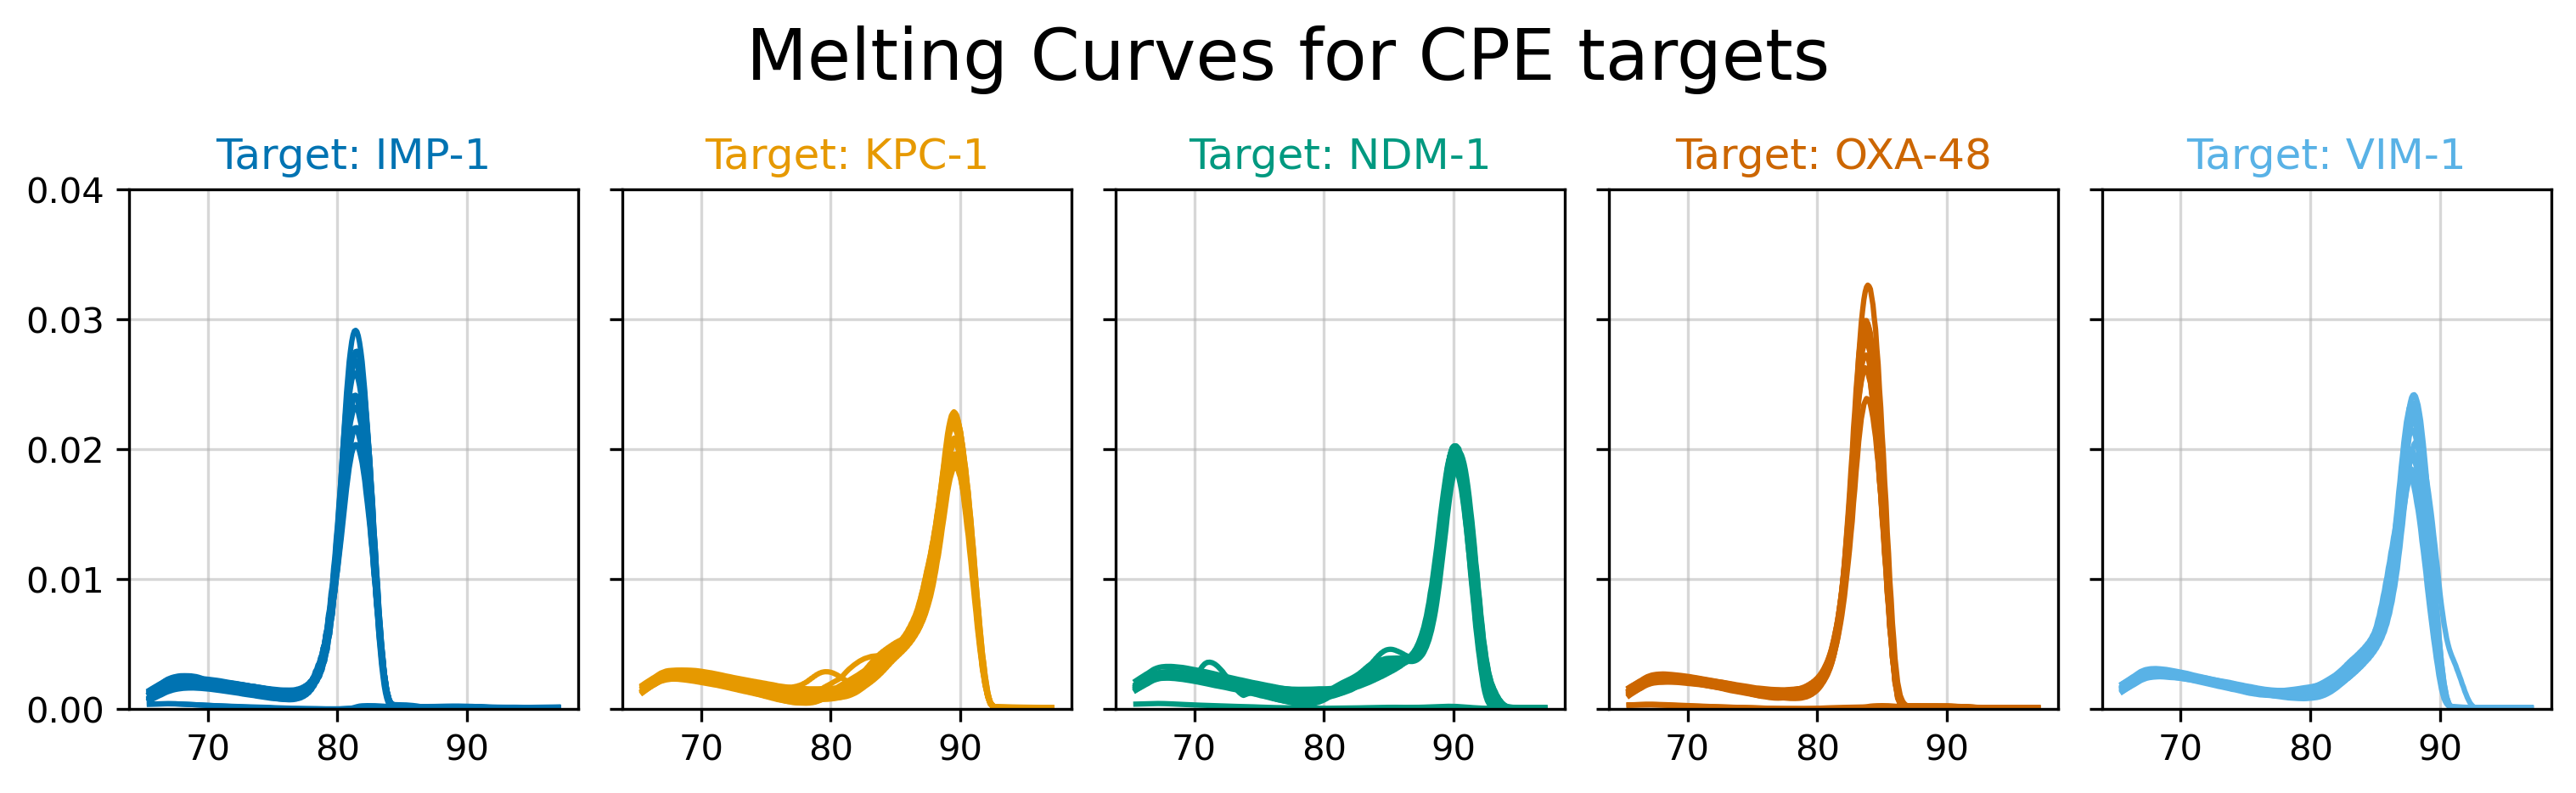

In [115]:
df_plot_MC = df_qMC_raw.loc[df_qMC_raw.Target!='NTC']

fig, ax = plt.subplots(1,5, figsize=(10, 3), dpi=300, constrained_layout=True)
fig.suptitle("Melting Curves for CPE targets", fontsize=20)
ax = ax.flatten()

for i, (target, df) in enumerate(df_plot_MC.groupby('Target')):
    ax[i].set_title(f"Target: {target}", c=f"C{i}")
    curves = df.iloc[:, qNMETA:]
    curves.columns = curves.columns.astype(float)
    curves = curves.transpose()
    
    ax[i].plot( curves.index, curves.values, c=f"C{i}")
    ax[i].grid(alpha=0.5)
    ax[i].set_ylim((0, 0.04))

    if i>0:
        ax[i].set_yticklabels([])
        
plt.show()